# Plot the results
To plot the results of taxonomic classifications, and different statistics from it. 
1. **Classification levels (without a taxonomy key)**: Just plot the percentage of sequences classified at different taxonomic levels, regardless of whether the classification is correct or not
2. **Classification levels (with taxonomy key)**: Plot the percentage of correctly and incorrectly classified sequences at different taxonomic levels, given a key taxonomy
3. **Compare community structure**: Plot the different compositions proposed by different methods 

In [ ]:
# To be specified
# Uncomment the part you want to run
# 1) Classification levels (without a taxonomy key)
samples = ['long reads']
input_taxonomy = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/metadata_converted.csv'

# 2) Classification levels (with a taxonomy key)
samples = ['long reads']
input_taxonomy = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/metadata_converted.csv'
taxonomy_key = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/True_species.txt'

# 3) Compare community structure
mock_community1 = ''
mock_community2 = ''

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Read the data
# Add as many rows a you need, depending on number of samples
data = pd.read_csv(input_taxonomy, index_col='Feature ID')

# Filter according to confidence
# For now, just drop the confidence level
data.drop('Confidence', axis=1, inplace=True)

### 1. Classification levels (without taxonomy key)

In [ ]:
def find_class_levels_nokey(dataframe):
    '''Takes a dataframe and calculates the number of sequences that have been classified (not NA) to the different
    taxonomical levels regardless of if the classification is correct or not.
    Input: Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    Output: Two dataframes containing:
    - N° sequences (in total) classified at each level (C*1)
    - N° sequences that have each taxonomic level as their highest (1*C)'''

    # Count number of not-null cells at each taxonomic level (column)
    class_all_levels = dataframe.notnull().sum()
    class_highest_level = class_all_levels.copy(deep=True)

    # Loop through the levels and calculate the number of sequences with each level as their highest classification
    for level in range(len(class_all_levels)-1):
        class_highest_level[level] -= class_all_levels[level+1]
    class_all_levels = class_all_levels.to_frame()
    class_highest_level = class_highest_level.to_frame().transpose()
    
    return class_all_levels, class_highest_level

In [12]:
# Calculate number of classifications
# In absolute numbers
all_levels, highest_levels = find_class_levels_nokey(data)

# In percentage
all_levels_ratio = all_levels.copy(deep=True)
highest_levels_ratio = highest_levels.copy(deep=True)
for sample in range(len(samples)):
    highest_levels_ratio.iloc[sample,:] /= highest_levels.iloc[sample,:].sum()
    all_levels_ratio.iloc[:, sample] /= highest_levels.iloc[sample,:].sum()

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_8399/698953841.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


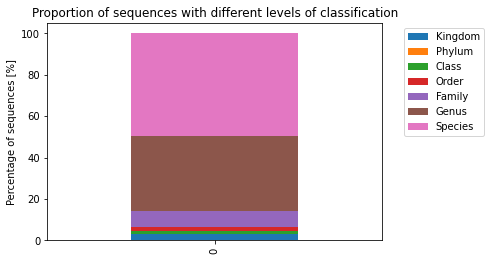

In [15]:
# Plot the results
fig, ax = plt.subplots()
highest_levels_ratio.plot(kind='bar', stacked=True, title='Proportion of sequences with different levels of classification', 
                        ylabel='Percentage of sequences [%]', ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

### 2. Classification levels (with taxonomy key)

In [ ]:
# Find misclassified sequences
def find_misclassified(dataframe, correct_classification):
    '''Checks if a classification is correct or not.
    Input: Two datasets
    - Dataframe: Putative classification
    - Correct_classification: Taxonomy key
    Output: A dataset identical to "dataframe", but with two additional columns.
    - Correct: True/False depending on if the classification is correct or not
    - Incorrect at: At what level a sequence is misclassified (if it is)'''

    # Create a copy to not mess with the original datafile
    dataframe_corrected = dataframe.copy(deep=True)

    # Loop through all sequences in the input
    # Check if the sequence with the same ID is classified in the same way in the key or not
        # If there is a NA in the classification:
        # If everything up until then is correct --> Correctly classified
        # If something before that is incorrect --> Incorrectly classified
    # Add the result as a new column ("Correct")
    for ID in dataframe.index:
        # If there is a NA
        if dataframe[dataframe.index == ID].isnull().any().any():
            correct_maybe = dataframe[dataframe.index == ID].compare(correct_classification[correct_classification.index == ID], align_axis=0)
            highest_level = correct_maybe.columns[0]
            if dataframe_corrected.isnull().loc[dataframe_corrected.index == ID, highest_level].values[0]:
                same = True
            else:
                same = False
        # If there is not a NA
        else:
            same = dataframe[dataframe.index == ID].equals(correct_classification[correct_classification.index == ID])
        
        # Add if the classification is correct or not to the dataset
        dataframe_corrected.loc[dataframe.index == ID, 'Correct'] = same

        # If the classification is incorrect: Add at what highest taxonomic level it is wrong
        if not same:
            incorrect_levels = dataframe[dataframe.index == ID].compare(correct_classification[correct_classification.index == ID], align_axis=0)
            dataframe_corrected.loc[dataframe.index == ID, 'Incorrect at'] = incorrect_levels.columns[0]
    
    return dataframe_corrected

In [ ]:
# Count the number of correct/incorrect classifications
def classification_stats(dataframe):
    '''Calculates:
    - N° correct classifications at each taxonomic level (in total)
    - N° sequences with their lowest (correct) classification at each level (ie correct species is shown as that, not as genus and family and ... kingdom)
    - N° incorrect klassifications at each highest level (ie wrong at family level is shown just as family, not as genus and species)
    Input: Dataframe with ['Feature ID', 'Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species', 'Correct', 'Incorrect at]
    Output: Two dataframes
    - N° sequences (in total) correctly classified at each level
    - N° sequences that are correctly and incorrectly classified at their lowest (correct) versus highest (incorrect) level
    '''

    # For all correctly classified sequences:
    # Calculate the total number of classifications at each level
    correct_sequences = dataframe[dataframe['Correct'] == True]
    correct_class_all_levels = correct_sequences.iloc[:, 0:-2].notnull().sum()
    
    # Calculate how many sequences have different taxonomic levels as their lowest classification
    class_levels = correct_class_all_levels.copy(deep=True)
    for level in range(len(correct_class_all_levels)-1):
        class_levels[level] -= correct_class_all_levels[level+1]
    
    # Convert to dataframes, transpose to the right dimensions for plotting
    correct_class_all_levels = correct_class_all_levels.to_frame()
    class_levels = class_levels.to_frame().transpose()

    # For all incorrectly classified sequences:
    # Add a column for each taxonomic level, in which the number of sequences which have been misclassified at that level
    # (as highest) is stored
    incorrect_sequences = dataframe[dataframe['Correct'] == False]
    for level in class_levels.columns:
        name = level + '_incorrect'
        n = len(incorrect_sequences[incorrect_sequences['Incorrect at'] == level])
        class_levels[name] = n

    return correct_class_all_levels, class_levels

In [ ]:
# Find misclassification for each dataset
short_corrected = find_misclassified(short_reads, taxonomy_key)
long_corrected = find_misclassified(long_reads, taxonomy_key)

# Calculate N° of correctly/incorrectly classified sequenced
correct_all_levels_short, class_levels_short = classification_stats(short_corrected)
correct_all_levels_long, class_levels_long = classification_stats(long_corrected)

# Collect them in one dataset (numbers in absolute values)
all_levels = pd.concat([correct_all_levels_long, correct_all_levels_short], axis=1)
all_levels.columns = samples
class_levels = pd.concat([class_levels_long, class_levels_short])
class_levels.index = samples

# Create an additional dataset where the numbers are in ratios
all_levels_ratio = all_levels.copy(deep=True)
class_levels_ratio = class_levels.copy(deep=True)
for sample in range(len(samples)):
    class_levels_ratio.iloc[sample,:] /= class_levels.iloc[sample,:].sum()
    all_levels_ratio.iloc[:, sample] /= class_levels.iloc[sample,:].sum()

In [ ]:
# Decide on the color maps for each taxonomic level, as well as for correct/incorrent classification
# Correct classification = Green
# Incorrect classification = Red
# Different taxonomic levels = Ligher or darker colors

# Number of taxonomic levels
n = len(class_levels.columns)/2

# Create the color maps
cmap_correct = plt.cm.get_cmap('Greens', n)
cmap_incorrect = plt.cm.get_cmap('Reds', n)

color_levels = {}
for i in range(int(n)):
    level_correct = class_levels.columns[i]
    color_levels[level_correct] = cmap_correct(i)

    level_incorrect = class_levels.columns[i+int(n)]
    color_levels[level_incorrect] = cmap_incorrect(i)

In [ ]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
fig, ax = plt.subplots()
class_levels_ratio.plot(kind='bar', stacked=True, color=color_levels, title='Proportion of sequences with different levels of classification', 
                        ylabel='Percentage of sequences [%]', ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# Plot the number of correctly classified sequences at different levels for each sample
fig, ax = plt.subplots()
all_levels_ratio.plot(grid=True, title='Ratio of sequences correctly classified at each taxonomic level', ylabel='Percentage of sequences [%]', ax=ax)
plt.show()

### 2.3 Compare community structure

In [ ]:
# Look through the dataset to find unique organisms, and how many times they have been classified
def find_organisms(dataframe):
    '''Takes a dataframe, find the lowest taxonomic level without a NA, and calculates how many times each variant at that level has been classified
    Input: Dataframe with sequences (rows, R) and taxonomical classification at different levels (columns, C)
    Output: Dataframe with all unique organisms at the lowest common taxonomic level, and how many times they are found'''
    # Create a copy to not mess with the original data
    # Find the cells with NA values
    dataframe_copy = dataframe.copy(deep=True)
    dataframe_null = dataframe_copy.isnull()

    # Iterate over all columns, starting at the lowest taxonomic level
    # If there is a NA in the column (a sequence hasn't been classified), drop the column
    for level in dataframe.columns[::-1]:
        if dataframe_null[level].any():
            dataframe_copy.drop(level, axis=1, inplace=True)
    
    # Remove all columns except the last one, which is the lowest taxonomic level at which all sequences have been classified
    dataframe_copy.drop(dataframe_copy.columns[:-1], axis=1, inplace=True)

    # Search for and count doublets (organisms present multiple times)
    # Add the count number of each organism in column "Count"
    # Index based on the organism's name
    dataframe_stats = dataframe_copy.groupby(dataframe_copy.columns.tolist()).size().reset_index(name='Count')
    dataframe_stats.index = dataframe_stats[dataframe_stats.columns[0]]
    dataframe_stats.drop(dataframe_stats.columns[0], axis=1, inplace=True)

    return dataframe_stats.transpose()

In [ ]:
# Run the function on all datasets
mock_community_structure_organisms = find_organisms(mock_community_structure)
mock_community_1_organisms = find_organisms(mock_community_1)
mock_community_2_organisms = find_organisms(mock_community_2)

# Add all samples to one large dataset
communities = pd.concat([mock_community_structure_organisms, mock_community_1_organisms, mock_community_2_organisms])
communities.index = ['Mock community ideal', 'Mock 1', 'Mock 2']

# Create an additional dataset with the numbers in percentage instead
communities_ratio = communities.copy(deep=True)
for sample in range(len(samples)+1):
    communities_ratio.iloc[sample,:] /= communities.iloc[sample,:].sum()

In [ ]:
# Plot the results
fig, ax = plt.subplots()
communities_ratio.plot(kind='bar', stacked=True, title='Community structure for different methods', ylabel='Percentage [%]', ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()